# Notebook to attempt to register 2 images of electrode placement

This will hopefully let us compare electrode placement across trials

## Imports

In [1]:
import os
import glob
# import imutils
import cv2

import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
import pandas as pd

from skimage.color import rgb2gray
from skimage.draw import circle_perimeter, disk
from skimage.feature import canny
from skimage.filters import threshold_otsu, sobel
from skimage.registration import phase_cross_correlation
from skimage.transform import hough_circle

from mosquito.util import set_plot_params

## Params

In [2]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize for x tick labels
plt.rc('ytick', labelsize=14)    # fontsize for y tick labels

plot_type = 'poster'  # 'paper' or 'powerpoint' or 'poster
plot_params = set_plot_params(plot_type=plot_type)


## Helper functions

In [3]:
def get_eyepiece_region(image, hough_radii=np.arange(450, 600, 5), canny_sigma=0.5, viz_flag=False):
    """
    Function to take in an RGB image taken from a phone (or whatever) 
    through the microscope eyepiece. We want to eventually register 
    these images

    Args:
        image: rgb image with cicular region of interest (to be obtained)
        hough_radii: values of radii for circles to look for in image
        canny_sigma: sigma for gaussian filter applied prior to canny edge detection
        viz_flag: boolean. visualize output?
        
    Returns:
        mask: binary mask with "1" corresponding to eyepiece region

    Need to have:
        from skimage.color import rgb2gray
        from skimage.draw import disk
        from skimage.feature import canny
        from skimage.transform import hough_circle
        from skimage.draw import circle_perimeter
        
    """
    # get edges in current image
    gray = rgb2gray(image.copy())
    edges = canny(gray, sigma=canny_sigma)

    # look for circles with hough transform
    print('Finding circles...')
    hough_res = hough_circle(edges, hough_radii)
    print('Done')
    
    # get most prominent circle(?)
    ridx, r, c = np.unravel_index(np.argmax(hough_res), hough_res.shape)
    print(f'Circle radius is: {hough_radii[ridx]}')

    # get circle coordinates and use to make mask
    mask = np.zeros(gray.shape, dtype='bool')
    circ_row, circ_col = disk((r, c), hough_radii[ridx], shape=mask.shape)
    mask[circ_row, circ_col] = True

    # visualize?
    if viz_flag:
        fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

        # original image
        ax0.imshow(image)
        ax0.set_axis_off()

        # overlay of mask and image
        ax1.imshow(image)
        ax1.imshow(mask, alpha=0.2)
        ax1.set_axis_off()
        
    return mask
    

In [4]:
def align_images(image, template, maxFeatures=500, keepPercent=0.2, viz_flag=False):
    """
    From https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/
    """
    # convert both the input image and template to grayscale
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # use ORB to detect keypoints and extract (binary) local
    # invariant features
    orb = cv2.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)
    # match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)
    
    # sort the matches by their distance (the smaller the distance,
    # the "more similar" the features are)
    matches = sorted(matches, key=lambda x:x.distance)
    # keep only the top matches
    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]
    
    # allocate memory for the keypoints (x, y)-coordinates from the
    # top matches -- we'll use these coordinates to compute our
    # homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    # loop over the top matches
    for (i, m) in enumerate(matches):
        # indicate that the two keypoints in the respective images
        # map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt
    
    # compute the homography matrix between the two sets of matched
    # points
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    # use the homography matrix to align the images
    (h, w) = template.shape[:2]
    aligned = cv2.warpPerspective(image, H, (w, h))

    # visualize?
    if viz_flag:
        # visualize
        fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,5))
        
        stereo_unaligned = np.zeros((template.shape[0], template.shape[1], 3))
        stereo_unaligned[...,0] = rgb2gray(template)
        stereo_unaligned[...,1] = rgb2gray(image)
        ax0.imshow(stereo_unaligned)
        ax0.set_axis_off()
        ax0.set_title('pre alignment overlay')
        
        stereo_aligned = np.zeros((template.shape[0], template.shape[1], 3))
        stereo_aligned[...,0] = rgb2gray(template)
        stereo_aligned[...,1] = rgb2gray(aligned)
        ax1.imshow(stereo_aligned)
        ax1.set_axis_off()
        ax1.set_title('post alignment overlay')
        
    # return the aligned image
    return aligned
    

## Try to loop through all images for a given day

In [11]:
# which experiment to look at?
data_root = '/media/sam/SamData/Mosquitoes'
data_folder = '66_20241115'


In [12]:
# read experiment log to grab fly info
log_path = os.path.join(data_root, 'experiment_log.xlsx')
log_df = pd.read_excel(log_path)

row_idx = (log_df['Day'] == data_folder)
log_df_expr = log_df[row_idx]
fly_nums = log_df_expr['Fly Num']

fly_nums_unique = np.unique(fly_nums.values)


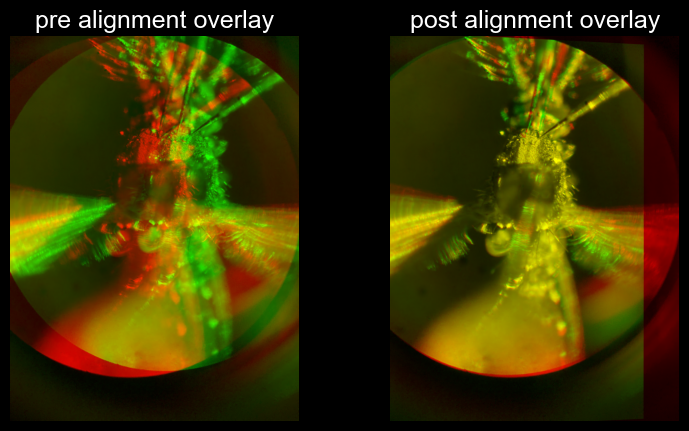

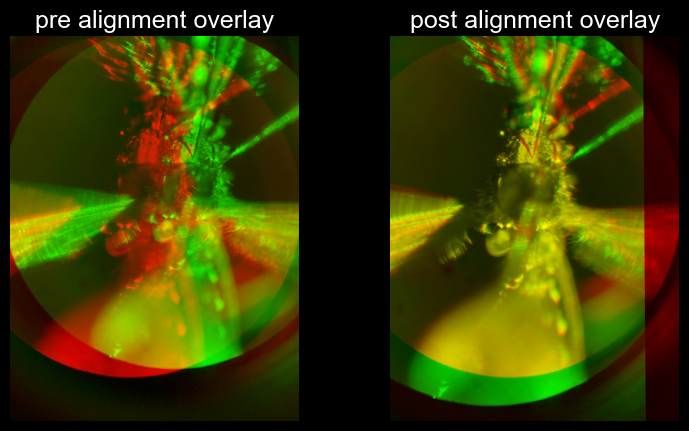

In [13]:
# Loop over flies and align all to common template
for fly_num in fly_nums_unique:
    # loop over trials with the same fly
    trials = log_df_expr[fly_nums == fly_num]
    axo_nums = trials['Axo Num'].astype(int)
    template_image = None
    
    for axo_num in axo_nums:
        # find the folder for the current axo file
        axo_paths = glob.glob(os.path.join(data_root, data_folder, '*', f'*_{int(axo_num):04d}.abf'))
        if not len(axo_paths) == 1:
            continue
        else:
            axo_path = axo_paths[0]
        axo_folder, _ = os.path.split(axo_path)
        image_path = glob.glob(os.path.join(axo_folder, '*.jpg'))

        if not len(image_path) == 1:
            print(f'Count not find electrode image for {data_folder}, {axo_num}')
            continue

        image_path = image_path[0]

        # read image
        image = iio.imread(image_path)
        
        # if this is the first image for the fly, store it as a template image. otherwise, align to template
        if template_image is None:
            # assign to template
            template_image = image.copy()
            aligned = image.copy()
        else:
            # otherwise, actually align
            aligned = align_images(image, template_image, viz_flag=True)

        # save new version of image
        save_path = image_path.replace('.jpg', '_aligned.jpg')
        iio.imwrite(save_path, aligned)

# Scratch

## Load data

In [5]:
# just get two images:
expr_path = '/media/sam/SamData/Mosquitoes/60_20241031'
im0_folder = '2024_10_31_0000'
im1_folder = '2024_10_31_0004'
im_fn = 'electrode_placement.jpg'


In [6]:
# load images
im0 = iio.imread(os.path.join(expr_path, im0_folder, im_fn))
im1 = iio.imread(os.path.join(expr_path, im1_folder, im_fn))              


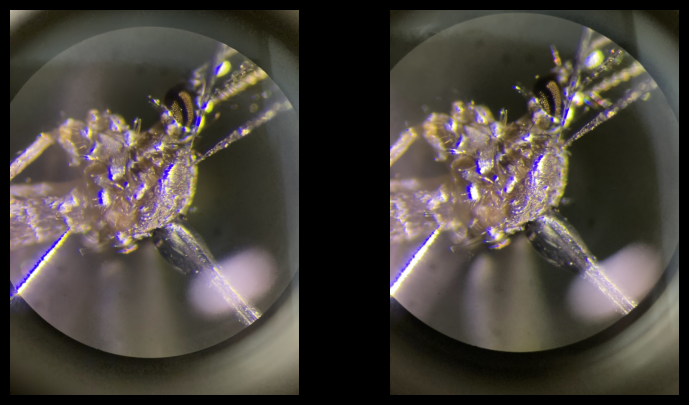

In [7]:
# visualize
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,5))

ax0.imshow(im0)
ax0.set_axis_off()

ax1.imshow(im1)
ax1.set_axis_off()

## Test alignment function

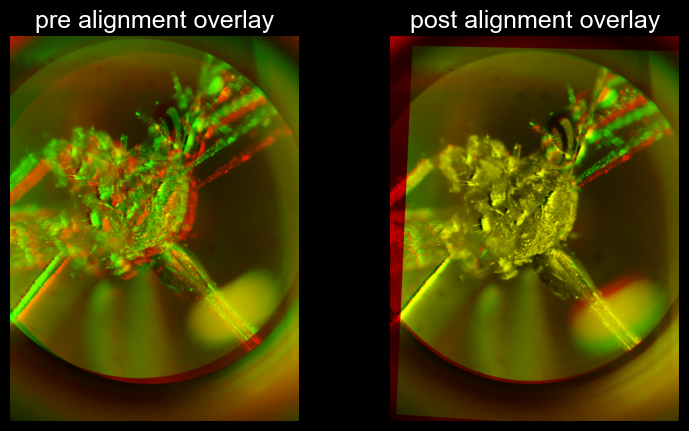

In [8]:
# try opencv approach from pyimagesearch
reference_image = im0.copy()
moving_image = im1.copy()

aligned = align_images(moving_image, reference_image, viz_flag=True)


## Determine mask for image -- want to exclude everything outside eyepiece

Finding circles...
Done
Circle radius is: 555


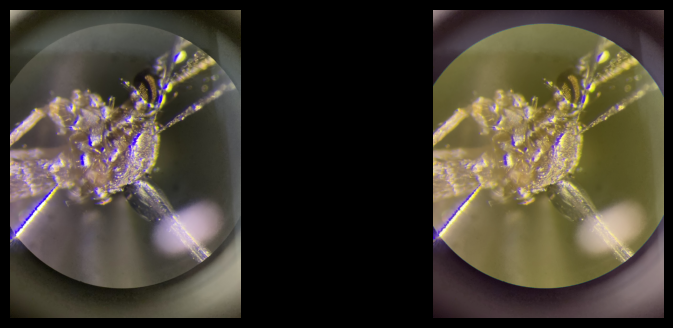

In [7]:
# try helper function
mask0 = get_eyepiece_region(im0, viz_flag=True)


Finding circles...
Done
Circle radius is: 570


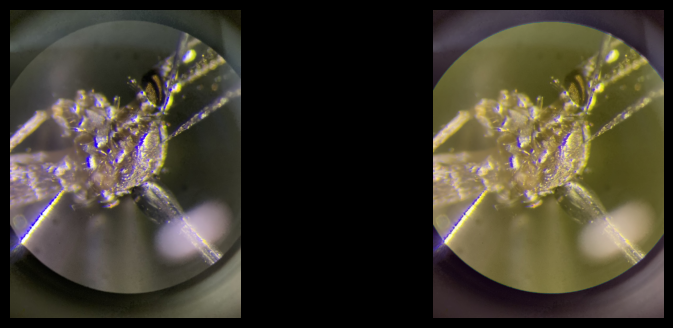

In [8]:
# try helper function
mask1 = get_eyepiece_region(im1, viz_flag=True)


## Can we now register these images using the eyepiece masks?

In [12]:
# trying Masked Normalized Cross-Correlation
reference_image = im0_gray.copy()
moving_image = im1_gray.copy()
detected_shift, error, phasediff = phase_cross_correlation(reference_image, moving_image, reference_mask=mask0, moving_mask=mask1)


In [13]:
detected_shift

array([ -7., -28.])

In [10]:
# try opencv approach from pyimagesearch
reference_image = im0.copy()
moving_image = im1.copy()
aligned = align_images(moving_image, reference_image)


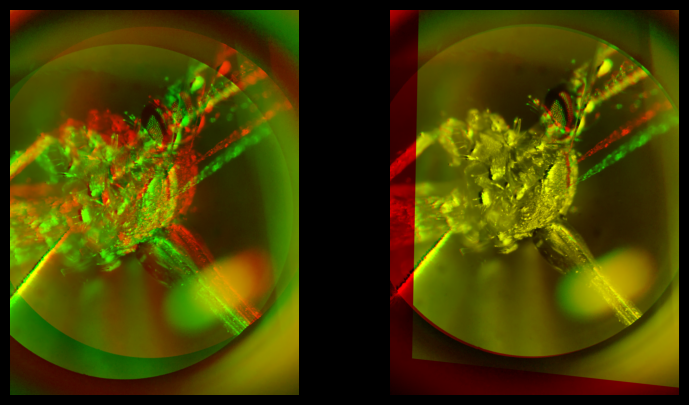

In [12]:
# visualize
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,5))

stereo_unaligned = np.zeros((im0.shape[0], im0.shape[1], 3))
stereo_unaligned[...,0] = rgb2gray(reference_image)
stereo_unaligned[...,1] = rgb2gray(moving_image)
ax0.imshow(stereo_unaligned)
ax0.set_axis_off()

stereo_aligned = np.zeros((im0.shape[0], im0.shape[1], 3))
stereo_aligned[...,0] = rgb2gray(reference_image)
stereo_aligned[...,1] = rgb2gray(aligned)
ax1.imshow(stereo_aligned)
ax1.set_axis_off()